In [393]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection    import GridSearchCV, train_test_split
from sklearn.metrics            import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm              import SVC
# from sklearn.neighbors        import KNeighborsClassifier

from xgboost                    import XGBClassifier 
from sklearn.pipeline           import Pipeline
# from sklearn.impute           import SimpleImputer
from sklearn.compose            import ColumnTransformer
from sklearn.preprocessing      import OneHotEncoder, StandardScaler, PolynomialFeatures   
from sklearn.feature_selection  import SelectKBest, f_classif, chi2

# Return pandas DataFrames instead of numpy arrays
# from sklearn import set_config
# set_config(transform_output="pandas") # ! NOT TESTED YET

Gold              = 1.618                          
Width             = 12
Height            = Width/Gold
WidthPx           = 1024
HeightPx          = WidthPx/Gold

k_result_file       = "models-benchmark"
k_target            = "converted"
k_header            = "conversion_data_test_predictions_"
k_author            = "PHILIPPE"
k_random_state      = 42            # I know you know ...
k_final_test_size   = 20/100        # typic. 20% from the set of the intial observations is set aside for final testing (unseen data)
k_test_size         = 20/100        # typic. 20% of the remaining 80% of the initial observation ui used for the test_set (we should say validation_set)
k_samples_ratio     = 100/100       # percentage of observations to be taken into account. Pass 100/100 for final testing 
k_bVerbose          = True          # Enable/disable messages
k_bPrePrepocessing  = False         # this flag indicates to do pre-preprocessing or not


### TODO & IDEAS

#### TODO
* ~~Pie chart pour illustrer le % de dupliqués~~
    * ~~Justifier la méthode de suppression de dupliqués~~
* ~~Vérifier si les distributions sont normales ou skew => 3 sigma ou 1.5 IQR~~
* ~~Show an example of minimal code without without framework~~
* Use set_config(transform_output="pandas")
* Reorganize code adding a python module 
  * this would help to read the notebook
* add a validation set and make sur to test the mode on unseen data before publication
* see how to transform "preprocessing on df" as a pre processing step
* see how to chain multiple pre processing
* see if it make sense to create a pre processing phase
* fix the vocabulary : 
  * Phase, step... 
  * A phase consists of one or more steps
  * Phases and steps are ordered
* Use ``set_config(transform_output="pandas")``
* review variables names
* ~~Classe déséquilibrées? - SMOTE - Synthetic Minority Oversampling Technique~~
* ~~Bar graph to illustrate 3% and unbalanced classes~~
* ~~can we re run the baseline example on one feature ?~~
  * ~~Yes. See ``Baseline`` selection id ~~
* ~~add graphs in EDA~~
* ~~split the dataset in 3 : train, test and final_test (unseen)~~
* ~~change organization in features engineering~~
* ~~verbosity~~
* ~~<span style="color:red"><b>BUG</b></span> : le dernier fichier de pred est vide ????~~
    * ~~warning at the very end~~

#### IDEAS
* Remove duplicate ?
* Remove outliers ?
* Lasso for feature selection
* ~~support for features engineering~~
* ~~support polyfeatures? Yes~~
* ~~test on one feature. Yes. See Baseline~~
* ~~Support for random forest. Yes~~
* ~~Support for feature selection. Yes~~
* ~~Any co linearity in features ?~~
  * ~~To be added in EDA~~
  * ~~Done with correlation heatmap~~ 
* ~~Are the distributions normal ?~~
  * ~~if needed log or boxCox~~
  * ~~See EDA~~




<!-- 

<span style="color:red"><b>BUG</b></span> : le dernier fichier de pred est vide ????

import ctypes   
ctypes.windll.user32.MessageBoxW(0, "Your text", "Your title", 1)

 -->

## Get the data

In [394]:
df = pd.read_csv('./assets/conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## EDA

In [395]:
print(f"Shape : {df.shape:}")
print()

display(df.describe(include="all").T)


Shape : (284580, 6)



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,284580,4,US,160124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,284580.0,NaN,NaN,NaN,30.564203,8.266789,17.0,24.0,30.0,36.0,123.0
new_user,284580.0,NaN,NaN,NaN,0.685452,0.464336,0.0,0.0,1.0,1.0,1.0
source,284580,3,Seo,139477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_pages_visited,284580.0,NaN,NaN,NaN,4.873252,3.341995,1.0,2.0,4.0,7.0,29.0
converted,284580.0,NaN,NaN,NaN,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


* Target = converted (bool)
* Classification problem
* 2 categorical features (country, source) 
* new_user is boolean
* 2 numerical features (age, total_pages_visited)
* There is much more than 30*nb_features so we should be safe

In [396]:
nb_converted      = df["converted"].sum()
nb_not_converted  = len(df)-nb_converted

print(f"Nb converted               : {nb_converted:>7_}")
print(f"Nb not converted           : {nb_not_converted:>7_}")
percent_converted = (100*nb_converted/(nb_converted+nb_not_converted)).round(2)
print(f"Nb converted as % of total : {percent_converted:>7_} %")

Nb converted               :   9_180
Nb not converted           : 275_400
Nb converted as % of total :    3.23 %


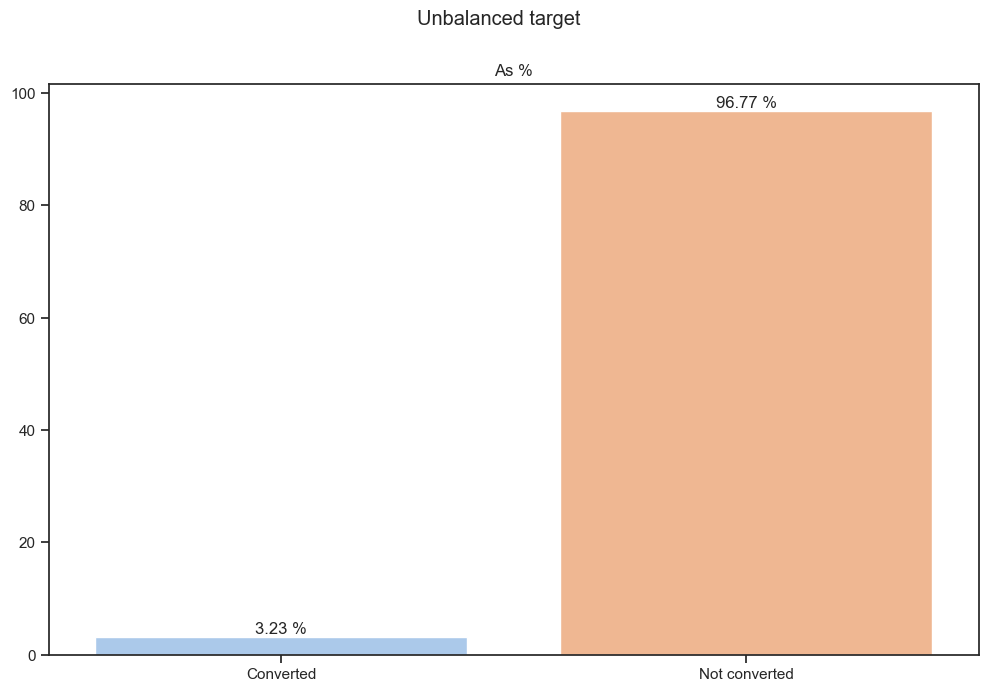

In [397]:
categories  = ['Converted', 'Not converted']
values     = [percent_converted, 100 - percent_converted]

fig, ax = plt.subplots(figsize=(Width,Height))
palette = sns.color_palette("pastel", n_colors=2)

sns.barplot (x=categories, y=values, hue = categories, palette=palette)                 
fig.suptitle("Unbalanced target")
ax.set_title("As %")
for i, val in enumerate(values):
    ax.text(i, val, str(val)+" %", ha='center', va='bottom')

### Comments : 

* Clearly the target is imblanced between converted and not converted.
* Let's make sure to use ``stratify`` while splitting the dataset
* Some good candidate could be : 
    * XGBoost (see the scale_pos_weight hyper parameter), 
    * Random Forest, 
    * AdaBoost 
    * and, why not, using some oversampling method (SMOTE)

In [398]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB
None


In [399]:
print(f"Number of null values :")
print()
print(100 * df.isnull().sum() / df.shape[0])
# print (df.isnull().any().any())

Number of null values :

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


In [400]:
print(f"Lines duplicated : {df.duplicated().sum():>6_}")
percent_duplicated = (100*df.duplicated().sum()/len(df)).round(2)
print(f"As %             : {percent_duplicated:>9_}%")

Lines duplicated : 268_769
As %             :     94.44%


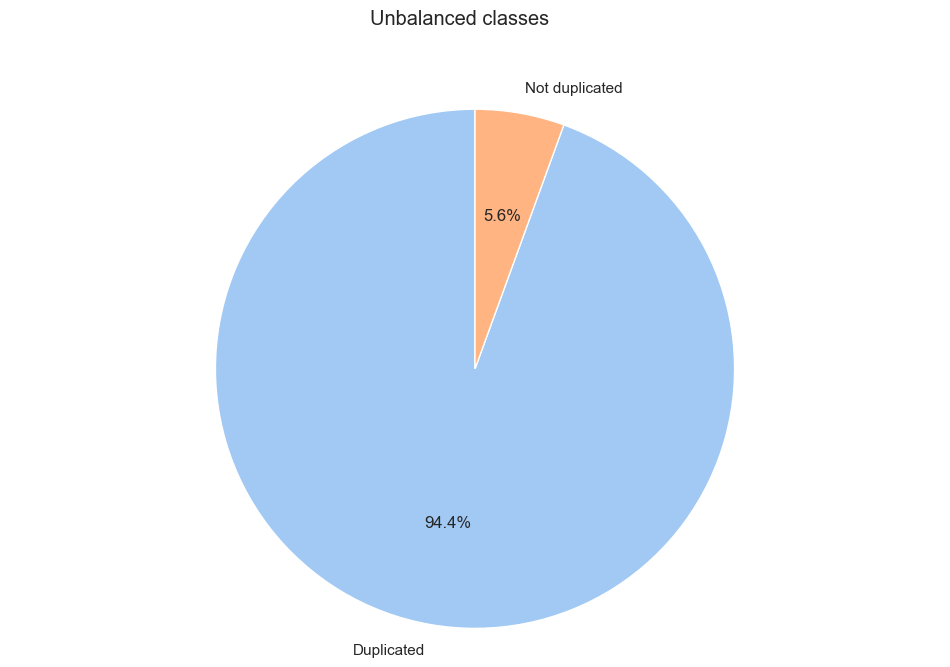

In [401]:
categories  = ['Duplicated', 'Not duplicated']
values      = [percent_duplicated, 100 - percent_duplicated]

fig, ax = plt.subplots(figsize=(Width, Height))
palette = sns.color_palette("pastel",n_colors=2)
ax.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=palette)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
fig.suptitle("Unbalanced classes")
plt.show()

In [402]:
print("Duplicated columns : ", df.columns.duplicated() )
print()

print("Unique countries   : ", df["country"].unique())
print("Unique sources     : ", df["source"].unique())


Duplicated columns :  [False False False False False False]

Unique countries   :  ['China' 'UK' 'Germany' 'US']
Unique sources     :  ['Direct' 'Ads' 'Seo']


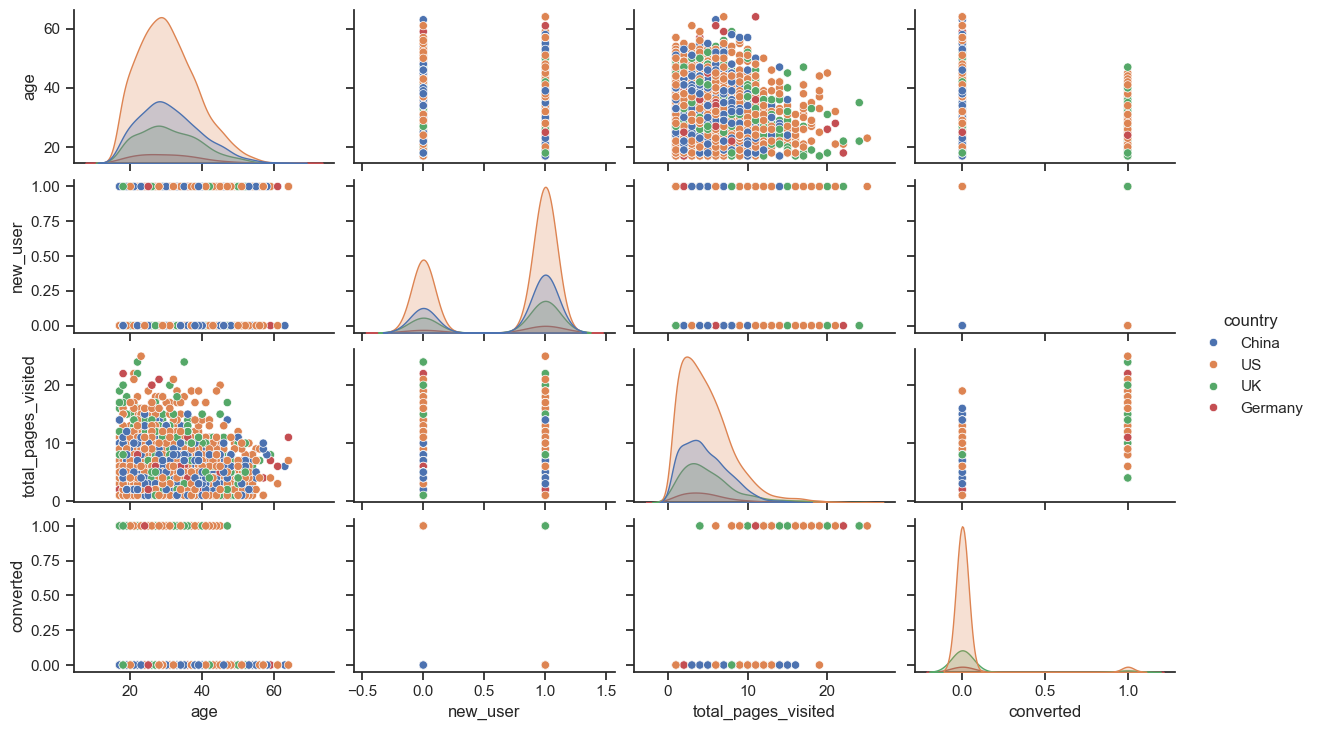

In [403]:
sns.set(style="ticks")
# Note the sample(5000) which helps to speedup things
_ = sns.pairplot(df.sample(5_000), hue="country", height=Height/4, aspect=Gold) 

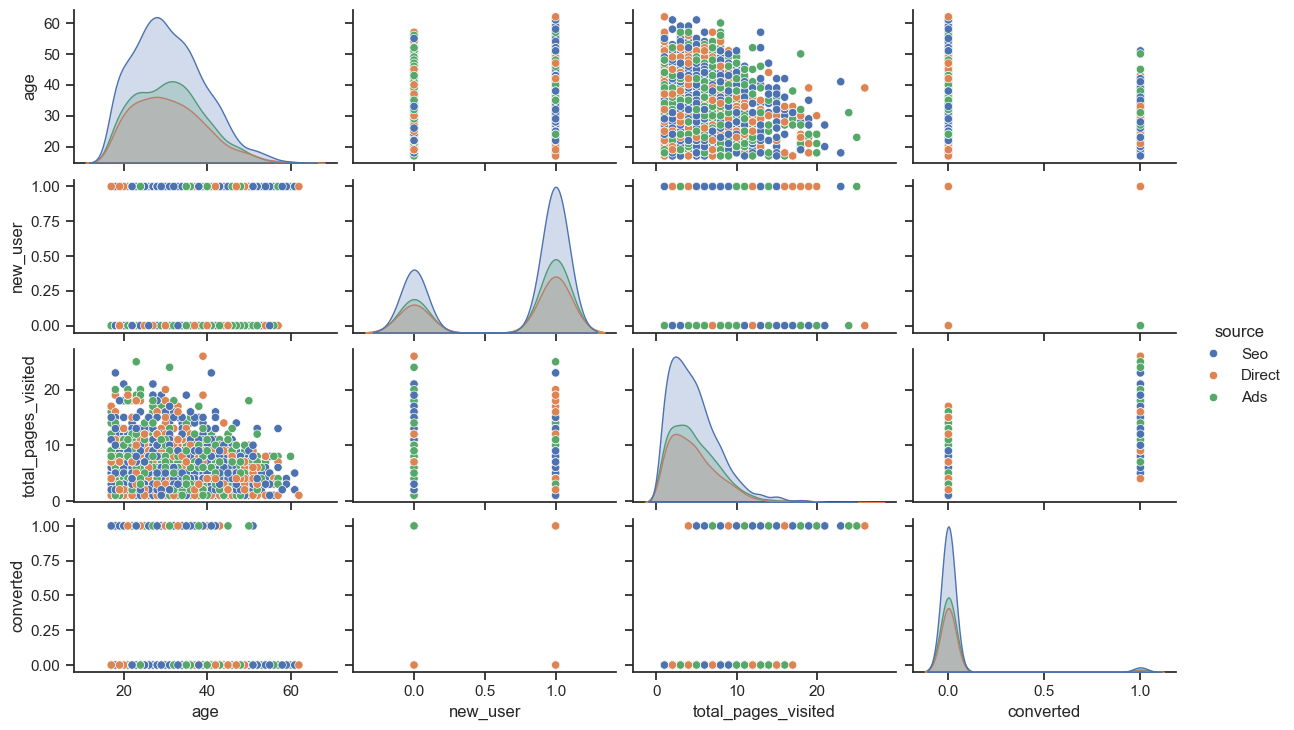

In [404]:
sns.set(style="ticks")
_ = sns.pairplot(df.sample(5_000), hue="source", height=Height/4, aspect=Gold)

### Comments : 
* ``total_pages_visited`` and ``age`` are NOT symetrical 
* => If we remove outliers, we should use 1.5 * IQR and NOT the 3 x $\sigma $

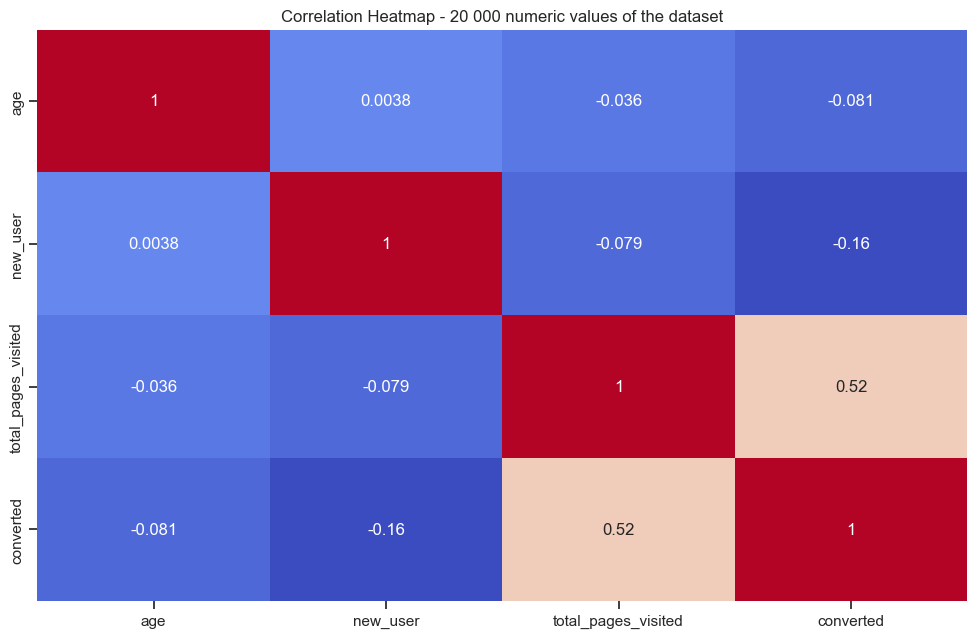

In [405]:
# Note the sample(20_000) which helps to speedup things
correlation_matrix = df.sample(20_000).corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(Width, Height))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=False)
ax.set_title("Correlation Heatmap - 20 000 numeric values of the dataset");


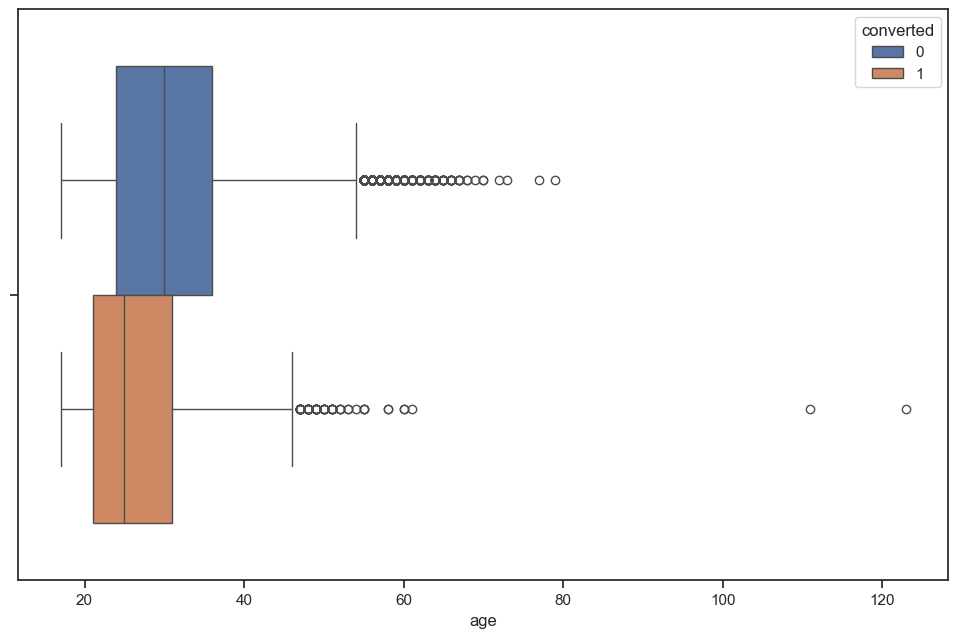

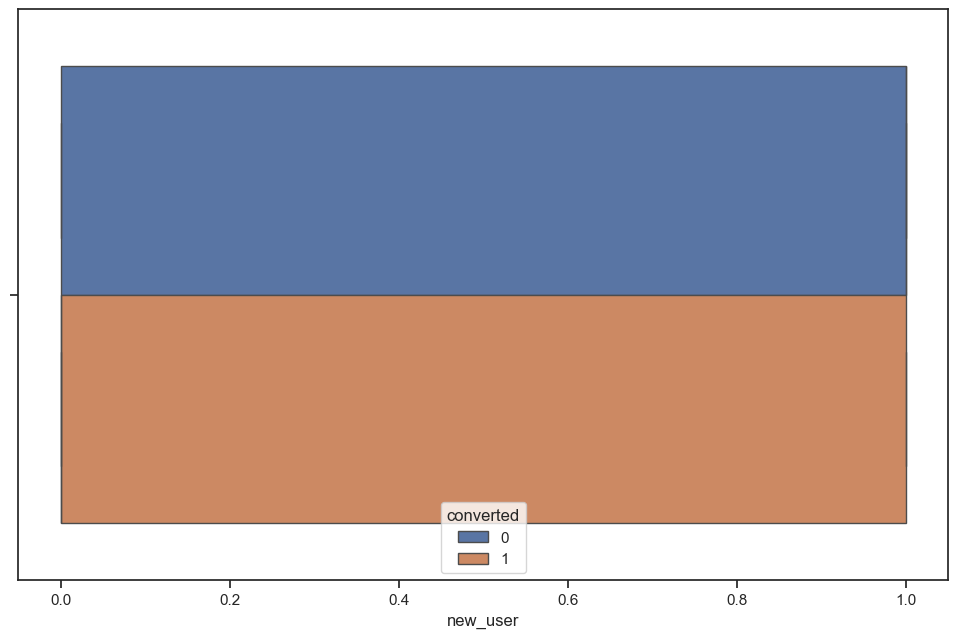

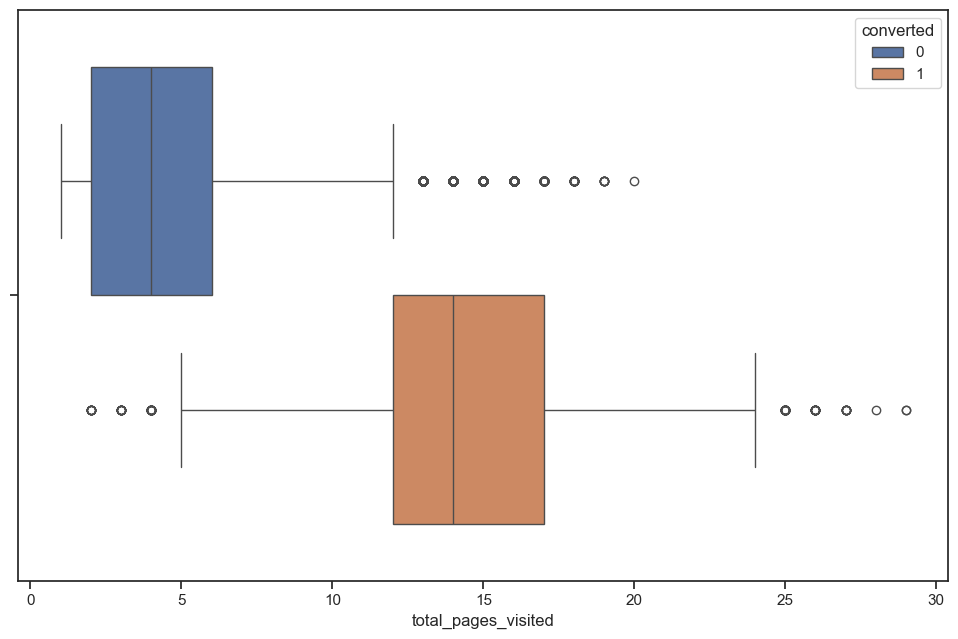

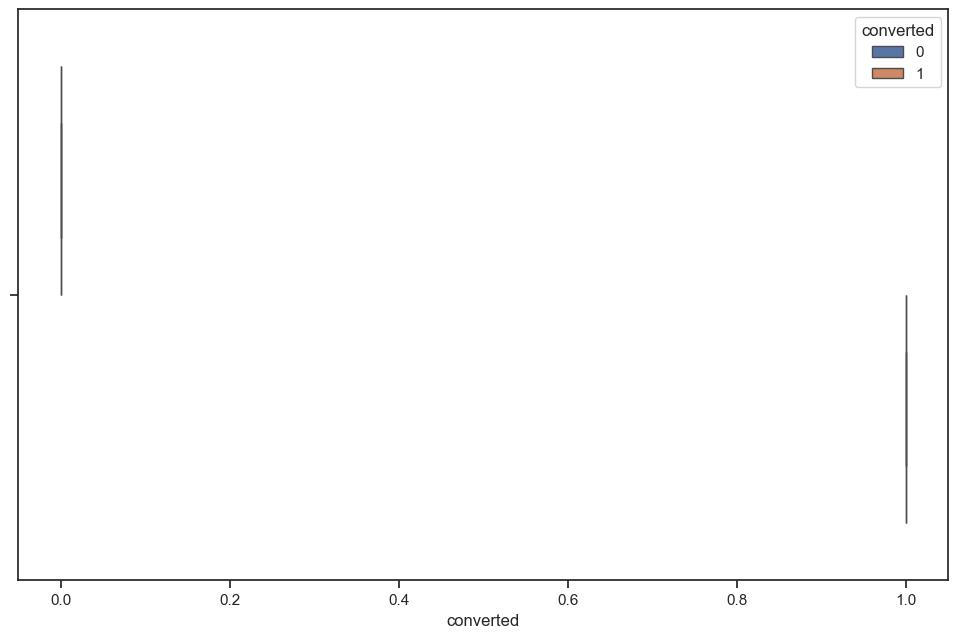

In [406]:
num_feat = df.select_dtypes(include="number").columns
for i, col in enumerate(num_feat):
  fig, ax = plt.subplots(figsize=(Width,Height))
  sns.boxplot(data=df, x=col, hue="converted")
plt.show()


## Sample code that works

* The code below works 
  * It trains a model on the dataset 
  * It records predictions made on the unlabeled observations
* Differents models have been tested and predictions sent to the leaderboard

In [407]:
# Uncomment the lines below if you copy paste this code frament
# Indeed, here it use what have been defined/included above
    # import pandas as pd
    # import numpy as np
    # from datetime import datetime
    # from sklearn.model_selection import train_test_split
    # from sklearn.metrics import f1_score, precision_score, recall_score  
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures   
    # from sklearn.compose import ColumnTransformer
    # from sklearn.linear_model import LogisticRegression 
    # from sklearn.pipeline import Pipeline

    # k_target        = "converted"
    # k_samples_ratio = 100/100   # percentage of observation to be taken into account. Pass 100/100 for final testing 
    # k_test_size     = 20/100    # see train_test_split
    # k_random_state  = 42        # you know why...
    # k_header        = "conversion_data_test_predictions_"
    # k_author        = "PHILIPPE"

df = pd.read_csv('./assets/conversion_data_train.csv')

#######################################################################
# training on train and test set
X = df.drop(columns = k_target)
y = df[k_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state, stratify = y)

numeric_features      = X.select_dtypes(include="number").columns
categorical_features  = X.select_dtypes(exclude="number").columns

numeric_transformer = Pipeline(
  steps=[
    ("scaler_num", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
      ("encoder_cat", OneHotEncoder(drop="first")),                 
  ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer,     numeric_features),
    ("cat", categorical_transformer, categorical_features),
  ]
)

X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

pipe = Pipeline(steps=[
    ("poly", PolynomialFeatures()),
    ("logit", LogisticRegression())
])

params = {
    "poly__degree"    : [1],
    "logit__C"        : [3, 0.1],
    "logit__penalty"  : ["none", "l2"],
}

gridsearch = GridSearchCV(pipe, param_grid = params, cv = 3, scoring="f1", n_jobs = -1)
gridsearch.fit(X_train, y_train)

best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X_test)

print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y_test,  y_pred):.6f} \t {precision_score(y_test,  y_pred):.6f} \t {recall_score(y_test,  y_pred):.6f}")

#######################################################################
# Training on the whole dataset
X = df.drop(columns = k_target)
y = df[k_target]

X = preprocessor.fit_transform(X)
gridsearch.fit(X, y)
best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X)

print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y,  y_pred):.6f} \t {precision_score(y,  y_pred):.6f} \t {recall_score(y,  y_pred):.6f}")

#######################################################################
# Prediction on unlabeled dataset
X_no_labels = pd.read_csv('./assets/conversion_data_test.csv')
X_no_labels = preprocessor.transform(X_no_labels)

data = {
  'converted': best_estimator.predict(X_no_labels)
}

y_predictions = pd.DataFrame(columns=['converted'], data=data)

trailer   = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file  = "./assets/" + k_header + k_author + "-" + trailer + ".csv"
y_predictions.to_csv(out_file, index=False)

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


f1 		 precision 	 recall
0.768485 	 0.866120 	 0.690632


c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


f1 		 precision 	 recall
0.763880 	 0.855176 	 0.690196


### Comments

* The most interresting part in the code above is the one close to GrideSearchCV() where :
    * We can define a pipe 
    * For each element of the pipe we define parameter values or range of values
* With this dataset, early results shown that a simple LogisticRegression was "good enough"
* Other than that we were spending time to fine tune parameters in order to increase the F1 score at the fourth decimal
* In addition the code above does not help to compare differents models (XGBoost vs LogisticeRegression vs XYZ model with a,b and c hyperparamaters)

This is the point where the idea of a kind of framework came up...

## About the code below

The end result was this one : 

<p align="center">
<img src="./assets/scores.png" alt="drawing" width="800"/>
<p>

Some of the key ideas :
1. Being able to compare results of differents models on the same dataset
1. Being able to test the same model but with different set of parameters
1. Act as a host for more sophisticated code
    * For example, some functions are in place but commented
1. Provide ranges of values for parameters and be able to find the best configuration for a model
    * This is supposed to be purely ``declarative`` in order to do many different tests quickly
    * No coding requested (this could be done in an external file)
1. Being able to use, not only a model but a pipe of Transformers, Predictors
    * Declarative, no coding 
    * Allow some sort of prepocessing "per model"  
1. Being able to easily add some pre-processing for all models under test
    * Specific code need to be added  - template already in place
    * 2 kinds of pre-precessing are identified. The ones acting on the read data and the ones working on X and y dataframes
1. In the same manner, be able to add some features selection for all models under test
    * Specific code need to be added - template already in place
1. Being able to add some feature engineering for all models under test
    * Specific code need to be added - template already in place
1. Define train, test and validation sets in order to make sure we can test the best model on "unseen" observations
1. Save the benchmarks results into csv files
1. Save the predictions of the best model in order to send them to the leaderboard
1. ...

When it is said ``declarative`` here above this is how it works :
* First, the user 'declare' a model to test as model_id and and a model_function (or pipe of transformers, predictors)

<p align="center">
<img src="./assets/models_naming.png" alt="drawing" width="800"/>
<p>

* Then it declares the parameters or range of parameters to be used 
* Doing so, one model can be tested with multiple sets of fixed parameters
* It can also be used with ranges of parameters for which we look for the best set

<p align="center">
<img src="./assets/models_settings.png" alt="drawing" width="800"/>
<p>

Here we can see that LogisticRegression() will be use (it is not commented) witht the configuration named LogisticeRegression_0 and LogisticeRegression_1. LogisticeRegression_0 correspond to the base line configuration. Every parmeter will be defaulted. LogisticeRegression_1 we will search for the best values of ``C`` and ``penalty``. 





## Pre-preprocessing

* Pre-prepocessing (!= preprocessing) is optional 
* It is made on the DataFrame before the target and the features are separated
* It impact all the subsequent operations and models

In [408]:
df = pd.read_csv('./assets/conversion_data_train.csv')

In [409]:
# utility function.
# print the name of the dataframe passed in a dict

def print_dict(dataframes_dict): 
  
  for df_name in dataframes_dict:
    df_actual = dataframes_dict.get(df_name)
    print(f"Shape of {df_name} : {df_actual.shape}")            if k_bVerbose == True else None


In [410]:
# Example 1 of pre_preprocessing_raw
# Remove outliers
# One col at a time
# Easier to understand

# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return df

# df = remove_outliers(df, 'age')
# df = remove_outliers(df, 'total_pages_visited')



In [411]:
# Example 2 of pre_preprocessing_raw
# Remove outliers
# Mask over both columns
# Might be faster

# col_of_interrest = df[["age", "total_pages_visited"]]

# # Q1, Q3, IQR are series
# Q1 = col_of_interrest.quantile(0.25)
# Q3 = col_of_interrest.quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers_mask = ((col_of_interrest < lower_bound) | (col_of_interrest > upper_bound)).any(axis=1)
# df = df[~outliers_mask]


In [412]:
X = df.drop(columns=k_target)
y = df[k_target]

In [413]:
if k_bVerbose : 
  print("X :")
  print(X.head())
  print(X.shape)
  print()

  print("y :")
  print(y.head())
  

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3
(284580, 5)

y :
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64


In [414]:
X_train_back, X_final_test, y_train_back, y_final_test = train_test_split(X, y, test_size=k_final_test_size, random_state=k_random_state, stratify = y)

dataframes_dict = {'Xtrain_back ': X_train_back, 'X_final_test': X_final_test, 'y_train     ': y_train_back, 'y_final_test': y_final_test}
print_dict(dataframes_dict)

# Uncomment the lines below to save X and y as .csv for additional testing on colab
# df_tmp = pd.concat([y, X], axis=1)
# df_tmp.to_csv("./assets/4test_colab.csv", index=False)



Shape of Xtrain_back  : (227664, 5)
Shape of X_final_test : (56916, 5)
Shape of y_train      : (227664,)
Shape of y_final_test : (56916,)


In [415]:
X_train, X_test, y_train, y_test = train_test_split(X_train_back, y_train_back, test_size=k_test_size, random_state=k_random_state, stratify = y_train_back)

dataframes_dict = {'X_train': X_train, 'X_test ': X_test, 'y_train': y_train, 'y_test ': y_test}
print_dict(dataframes_dict)



Shape of X_train : (182131, 5)
Shape of X_test  : (45533, 5)
Shape of y_train : (182131,)
Shape of y_test  : (45533,)


In [416]:

# TODO : see how to transform this code as a pre processing step
# TODO : find a way to link as in a receipt differents step in pre processing (what about seleciotb etc.)

# This pre-preprocessing differs from the previous one 
# Indeed, it is defined as a function
# It act on two dataframes X and y while the previous one acted on the read values (df) 

def pre_preprocessing(X, y):
  
  df_tmp = pd.concat([y, X], axis=1)

  # This is an example
  df_tmp['weight'] = df_tmp.groupby(df_tmp.columns.tolist(), sort=False).transform('size')
  
  # This is anothor example - Remove duplicates
  # df_tmp = df_tmp.drop_duplicates()

  # Dangerous ? Here I suppose y is always the first col 
  # See concat above
  X = df_tmp.drop(df_tmp.columns[0], axis=1)
  y = df_tmp.iloc[:,0]

  return X, y


In [417]:
if(k_bPrePrepocessing):
  print(f"shape : {X_train.shape}") if k_bVerbose == True else None
  print(f"shape : {y_train.shape}") if k_bVerbose == True else None
  
  X_train, y_train = pre_preprocessing(X_train, y_train)  

  print(f"shape : {X_train.shape}") if k_bVerbose == True else None
  print(f"shape : {y_train.shape}") if k_bVerbose == True else None

  display(X_train.head(2)) if k_bVerbose == True else None
  

In [418]:
if(k_bPrePrepocessing):
  print(f"shape : {X_test.shape}") if k_bVerbose == True else None
  print(f"shape : {y_test.shape}") if k_bVerbose == True else None
  
  X_test, y_test = pre_preprocessing(X_test, y_test)  

  print(f"shape : {X_test.shape}") if k_bVerbose == True else None
  print(f"shape : {y_test.shape}") if k_bVerbose == True else None

  display(X_test.head(2)) if k_bVerbose == True else None


In [419]:
# We can either use X_train or X_test to list the names of numerical/categorical columns

numeric_features = X_train.select_dtypes(include="number").columns
print(numeric_features) if k_bVerbose == True else None

categorical_features = X_train.select_dtypes(exclude="number").columns
print(categorical_features) if k_bVerbose == True else None



Index(['age', 'new_user', 'total_pages_visited'], dtype='object')
Index(['country', 'source'], dtype='object')


In [420]:
# The commented lines might be useful with others dataset

numeric_transformer = Pipeline(
  steps=[
    # ("imputer_num", SimpleImputer()),
    # ("imputer_num", SimpleImputer(strategy="mean")),
    ("scaler_num", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
    # ("imputer_cat", SimpleImputer(fill_value="missing", strategy="constant")),  
    # ("imputer_cat", SimpleImputer(strategy="most_frequent")),  
    # ("encoder_cat", OneHotEncoder(handle_unknown='ignore', sparse=False)),                 
    ("encoder_cat", OneHotEncoder(drop="first")),                 
  ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer,     numeric_features),
    ("cat", categorical_transformer, categorical_features),
  ]
)


In [421]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(X_train[0:5].round(3))    if k_bVerbose == True else None

# ! IMPORTANT : because in this script we work with df NOT nd array 
X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
display(X_train.head())         if k_bVerbose == True else None

X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

[[ 0.537  0.676  0.934  0.     0.     1.     0.     0.   ]
 [-0.791  0.676 -0.562  0.     0.     0.     1.     0.   ]
 [-0.429  0.676 -1.16   0.     0.     0.     0.     1.   ]
 [ 0.9    0.676 -1.16   0.     0.     0.     0.     0.   ]
 [-0.429  0.676 -0.562  0.     0.     0.     0.     1.   ]]


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.537447,0.676139,0.934158,0.0,0.0,1.0,0.0,0.0
1,-0.790909,0.676139,-0.561734,0.0,0.0,0.0,1.0,0.0
2,-0.428630,0.676139,-1.160091,0.0,0.0,0.0,0.0,1.0
3,0.899726,0.676139,-1.160091,0.0,0.0,0.0,0.0,0.0
4,-0.428630,0.676139,-0.561734,0.0,0.0,0.0,0.0,1.0


In [422]:
def apply_feature_engineering(data, strategy='None', **kwargs):

  """
  Applies a feature engineering strategy to the data.      

  Args: 
  - data (DataFrame)  : The DataFrame containing the initial data.     
  - strategy (str)    : The feature engineering strategy to apply.     
  - kwargs            : Parameters specific to the feature engineering strategy.      

  Returns (DataFrame) : The DataFrame containing the transformed data.     
  """

  match strategy:

    case 'None':
      transformed_df = data.copy()
     
    case 'polynomial_features':
      degree = kwargs.get('degree', 2)          # 2 by default
      poly = PolynomialFeatures(degree=degree)
      transformed_data = poly.fit_transform(data)

      original_feature_names = data.columns
      feature_combinations = poly.powers_

      # Generate names for the new features
      feature_names = [""]
      for feature_combination in feature_combinations[1:]:
          new_feature_name = "*".join([f"{orig_feature}^{power}" if power > 1 else orig_feature for orig_feature, power in zip(original_feature_names, feature_combination)])
          feature_names.append(new_feature_name)

      # new df - transformed features and their names
      transformed_df = pd.DataFrame(transformed_data, columns=feature_names)

    case 'log_transform':
      features_to_transform = kwargs.get('features_to_transform', [])
      transformed_df = data.copy()
      transformed_df[features_to_transform] = np.log(data[features_to_transform] + 1) # log neperien

    case 'custom_feature_engineering':
      # Design your own pizza here
      # One can use kwargs
      transformed_df = data.copy()

    case _:
      raise ValueError("Feature engineering strategy not recognized.")

  return transformed_df

In [423]:
def apply_feature_selection(X_train, y_train, X_test, feature_selection_id='None', **kwargs):

  """
  Applies a feature selection strategy to the data.      

  Args: 
  - X_train, y_train, X_test (DataFrame)  : the dataframe
  - feature_selection_method (str)        : default None. The delection to be applied     
  - kwargs                                : Parameters specific to the feature selection strategy      

  Returns (DataFrame)                     : The DataFrame containing the selected features     
  """

  match feature_selection_id:
      case "None":
        X_train_selected_df = X_train
        X_test_selected_df = X_test
               
      case 'SelectKBest':
        k = kwargs.get('k', 10)                            # 10 by default
        if df.shape[1]<k:
          k = df.shape[1]
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
        X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train.columns[selector.get_support()])

      case 'chi2':
        selector = SelectKBest(score_func=chi2)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
        X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train.columns[selector.get_support()])

      case 'Baseline':
        features_list = kwargs.get('features_list', [])
        X_train_selected_df = X_train.loc[:, features_list]
        X_test_selected_df = X_test.loc[:, features_list]

      case 'Baseline2':
        features_list = kwargs.get('features_list', [])
        X_train_selected_df = X_train.loc[:, features_list]
        X_test_selected_df = X_test.loc[:, features_list]

      case 'custom_feature_selection':
        # Design your own pizza here
        # One can use kwargs
        X_train_selected_df = X_train
        X_test_selected_df = X_test
      
      case _:
        raise ValueError("Feature selection method not recognized.")

  return X_train_selected_df, X_test_selected_df


In [424]:
def evaluate_model_scores(model, params, X_train, y_train, X_test, y_test):

  grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=-1)
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print(best_params)                        if k_bVerbose == True else None

  # ! don't do that. Bad idea
  # best_estimator = gridsearch.best_estimator_
  # Do this instead
  model.set_params(**best_params)
  # https://stackoverflow.com/questions/69326639/sklearn-warning-valid-feature-names-in-version-1-0
  model.fit(X_train.values, y_train)
  y_pred = model.predict(X_test.values)

  scores = {
    'accuracy'  : accuracy_score  (y_test, y_pred),
    'precision' : precision_score (y_test, y_pred),
    'recall'    : recall_score    (y_test, y_pred),
    'f1'        : f1_score        (y_test, y_pred)
  }

  print(f1_score(y_test, y_pred))           if k_bVerbose == True else None

  return scores


In [425]:
# A dataframe to store the results
results_df = pd.DataFrame(columns=["Pre_processing", 'Feature_Engineering', 'Feature_Selection', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1'])



# Features Engineering Strategies

In [426]:
# Strategies for feature engineering
# At least one strategy MUST be active
# fes stands for features engineering strategies
# One fes = fes id + fes function
# You can define as many selection id as you like
# Make sure to define a set of parameters (even if there is no parameters) for each selection id
feature_engineering_strategies = [
  ('None'           , "None"),
  # ("Poly Feat"      , "polynomial_features"),       # degree
  # ("Log Transform"  , "log_transform"),             # features_to_transform
]

# Define paramter for each strategy
# You can let them uncommented
engineering_params_sets = {
  'None'            : {},
  'Poly Feat'       : {'degree':1},                         
  'Log Transform'   : {'features_to_transform': [0, 1, 2]}, # ! NOT TESTED!!!!!!!!!!!!!! 
}


# Features Selection Strategies

In [427]:

# TODO : simply. Indeed, only tje selection_id is needed
# Strategies for feature selection
# At least one strategy id MUST be active
# You can define as many selection id as you like
# Make sure to define a set of parameters (even if there is no parameter) for each selection id
feature_selection_strategies = [
  ('None'),
  #('Baseline'),
  #('Baseline2'),
  # ('SelectKBest_2'), 
  # ("SelectKBest_1") , 
  # ('chi2'),                            # !!! PAS TESTE
]

# Define paraameters for each strategy
# You can let them uncommented
selection_params_sets = {
  'None'          : {},
  'Baseline'      : {'features_list' : ['num__total_pages_visited'] }, # pay attention to the num__ (double underscore)
  'Baseline2'     : {'features_list' : ['num__total_pages_visited', 'num__age'] }, 
  'SelectKBest_1' : {'k':1},                         
  'SelectKBest_2' : {'k':2},                         
  'chi2'          : {}, 
}


# Models & Hyperparameters

In [428]:
# A model = a model id and a model function
# You can define as many model id as you like
# Make sure to define a set of parameters (even if there is no parameters) for each model id

pipe_4 = Pipeline(steps=[
    ("poly", PolynomialFeatures()),
    ("logit", LogisticRegression())
])

models = [
    ("LogisticRegression_0", LogisticRegression()),
    # ("LogisticRegression_1", LogisticRegression()),
    #("LogisticRegression_2", LogisticRegression()),
    # ("LogisticRegression_3", LogisticRegression()),
    ("LogisticRegression_4", pipe_4),
    
    ("RandomForestClassifier_0", RandomForestClassifier()),
    # ('Random Forest', RandomForestClassifier()),
    
    # ('XGBoost', XGBClassifier()),
    # ("Gradient Boost Clf", GradientBoostingClassifier())
    # ('SVM', SVC()),
    # ('KNN', KNeighborsClassifier()),
]

# Set of hyperparameters for each model_id
models_params_sets = {
    'LogisticRegression_0'      : {},          # baseline model
    'LogisticRegression_1'      : {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'LogisticRegression_2'      : {'C': [100], 'max_iter': [1000], 'random_state': [k_random_state]},
    'LogisticRegression_3'      : {'penalty' : ['l2', 'None'], 'C': [0.01, 0.1, 1, 10], 'class_weight' : ['None', 'dic', 'balanced'], 'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'random_state': [k_random_state]},
    'LogisticRegression_4'      : {"poly__degree" : [1], "logit__C" : [3, 0.1], "logit__penalty" : ["none", "l2"], },
    'LogisticRegression_99'     : {'C' : [0.75 + i * 0.05 for i in range(20)], 'solver' : ['lbfgs', "saga", "newton-cholesky", 'newton-cg', 'sag']},       # 'random_state': [k_random_state]},
    'RandomForestClassifier_0'  : {"n_estimators" : [200], "max_depth":[20], "min_samples_split":[20], "min_samples_leaf":[4], "max_features":["sqrt"], "random_state":[42]},
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
    'Random Forest'             : {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
    'SVM'                       : {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN'                       : {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'XGBoost'                   : {'booster':['gbtree']},
    # https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    "Gradient Boost Clf"        : {'learning_rate' : [0.1, 0.01], 'n_estimators': [100, 200], 'subsample' : [1.0, 0.8]},
}



In [429]:
results_lst=[]

# fes = Feature Engineering Strategy
for fes_id, fes_fn in feature_engineering_strategies:
  
  display(X_train.head(5))                        if k_bVerbose == True else None
  print("X_train            : ", type(X_train))   if k_bVerbose == True else None

  # Loop over feature engineering
  X_train_engineered = apply_feature_engineering(X_train, fes_fn, **engineering_params_sets[fes_id])
  X_test_engineered  = apply_feature_engineering(X_test,  fes_fn, **engineering_params_sets[fes_id])
  # DataFrame
  display(X_train_engineered.head(5))                       if k_bVerbose == True else None
  print("X_train_engineered : ", type(X_train_engineered))  if k_bVerbose == True else None

  # Loop over features selection
  for selection_id in feature_selection_strategies:
    X_train_selected, X_test_selected = apply_feature_selection(X_train_engineered, y_train, X_test_engineered, selection_id, **selection_params_sets[selection_id])
    # DataFrame
    display(X_train_selected.head(5))                       if k_bVerbose == True else None
    print("X_train_selected   : ", type(X_train_selected))  if k_bVerbose == True else None
    
    # Loop over models
    for model_id, model_fn in models:
      print(f"{fes_id}-{selection_id}-{model_id} : ")
      scores = evaluate_model_scores(model_fn, models_params_sets[model_id], X_train_selected, y_train, X_test_selected, y_test)
      
      results_lst.append(
        {
          'Pre_processing'      : k_bPrePrepocessing,
          'Feature_Engineering' : fes_id,
          'Feature_Selection'   : selection_id,
          'Model'               : model_id,
          'Accuracy'            : scores['accuracy'],
          'Precision'           : scores['precision'],
          'Recall'              : scores['recall'],
          'F1'                  : scores['f1']
        }
      )

results_df = pd.concat([pd.DataFrame([result]) for result in results_lst], ignore_index=True)
print("Scores on test set, ordered by F1 descending : ")
display(results_df.sort_values(by="F1", ascending=False))

# Save the results of the benchmark in a csv file
trailer = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = "./assets/" + k_result_file + "-" + trailer + ".csv"
results_df.to_csv(out_file, encoding="utf8")


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.537447,0.676139,0.934158,0.0,0.0,1.0,0.0,0.0
1,-0.790909,0.676139,-0.561734,0.0,0.0,0.0,1.0,0.0
2,-0.428630,0.676139,-1.160091,0.0,0.0,0.0,0.0,1.0
3,0.899726,0.676139,-1.160091,0.0,0.0,0.0,0.0,0.0
4,-0.428630,0.676139,-0.561734,0.0,0.0,0.0,0.0,1.0


X_train            :  <class 'pandas.core.frame.DataFrame'>


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.537447,0.676139,0.934158,0.0,0.0,1.0,0.0,0.0
1,-0.790909,0.676139,-0.561734,0.0,0.0,0.0,1.0,0.0
2,-0.428630,0.676139,-1.160091,0.0,0.0,0.0,0.0,1.0
3,0.899726,0.676139,-1.160091,0.0,0.0,0.0,0.0,0.0
4,-0.428630,0.676139,-0.561734,0.0,0.0,0.0,0.0,1.0


X_train_engineered :  <class 'pandas.core.frame.DataFrame'>


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.537447,0.676139,0.934158,0.0,0.0,1.0,0.0,0.0
1,-0.790909,0.676139,-0.561734,0.0,0.0,0.0,1.0,0.0
2,-0.428630,0.676139,-1.160091,0.0,0.0,0.0,0.0,1.0
3,0.899726,0.676139,-1.160091,0.0,0.0,0.0,0.0,0.0
4,-0.428630,0.676139,-0.561734,0.0,0.0,0.0,0.0,1.0


X_train_selected   :  <class 'pandas.core.frame.DataFrame'>
None-None-LogisticRegression_0 : 
{}
0.7407129455909943
None-None-LogisticRegression_1 : 
{'C': 10, 'penalty': 'l2'}
0.7404351087771943
None-None-LogisticRegression_4 : 


c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


{'logit__C': 3, 'logit__penalty': 'none', 'poly__degree': 1}


c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


0.7404351087771943
None-None-RandomForestClassifier_0 : 
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 200, 'random_state': 42}
0.7342995169082126
Scores on test set, ordered by F1 descending : 


,Pre_processing,Feature_Engineering,Feature_Selection,Model,Accuracy,Precision,Recall,F1
0,False,None,None,LogisticRegression_0,0.984824,0.825251,0.671886,0.740713
1,False,None,None,LogisticRegression_1,0.984802,0.824561,0.671886,0.740435
2,False,None,None,LogisticRegression_4,0.984802,0.824561,0.671886,0.740435
3,False,None,None,RandomForestClassifier_0,0.984297,0.808511,0.672566,0.734300


### <span style="color:orange"><b>RESULTS : Benchmarks on Test Set </b></span>

## Training on the whole dataset 
* DOES NOT INCLUDE X_final_test nor y_final_test 
* No division between train and test set
* The idea is to leverage the maximum of observations to adjust model's parameters

In [431]:
# Copy X_train_back and y_train_back
# to act as if we were working on the whole dataset

X = X_train_back.copy()
y = y_train_back.copy()

print(f"Shape of X : {X.shape}") if k_bVerbose == True else None
print(f"Shape of y : {y.shape}") if k_bVerbose == True else None



Shape of X : (227664, 5)
Shape of y : (227664,)


In [432]:
if(k_bPrePrepocessing):
  print(f"shape : {X.shape}") if k_bVerbose == True else None
  print(f"shape : {y.shape}") if k_bVerbose == True else None
  
  X, y = pre_preprocessing(X, y)  

  print(f"shape : {X.shape}") if k_bVerbose == True else None
  print(f"shape : {y.shape}") if k_bVerbose == True else None

  display(X.head(2)) if k_bVerbose == True else None


In [433]:
X = preprocessor.fit_transform(X)
print(X[0:5].round(3))  if k_bVerbose == True else None

# ! IMPORTANT because is this code we "play" with df NOT nd arrays
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
display(X_train.head()) if k_bVerbose == True else None

print(X.shape)          if k_bVerbose == True else None
print(type(X))          if k_bVerbose == True else None


[[-1.277  0.676 -0.262  0.     0.     1.     0.     0.   ]
 [-0.189  0.676 -0.561  0.     0.     0.     0.     0.   ]
 [ 0.657 -1.479 -0.561  0.     0.     1.     0.     1.   ]
 [-0.914  0.676  0.934  0.     0.     1.     0.     1.   ]
 [ 1.262  0.676 -0.561  0.     1.     0.     0.     0.   ]]


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.537447,0.676139,0.934158,0.0,0.0,1.0,0.0,0.0
1,-0.790909,0.676139,-0.561734,0.0,0.0,0.0,1.0,0.0
2,-0.428630,0.676139,-1.160091,0.0,0.0,0.0,0.0,1.0
3,0.899726,0.676139,-1.160091,0.0,0.0,0.0,0.0,0.0
4,-0.428630,0.676139,-0.561734,0.0,0.0,0.0,0.0,1.0


(227664, 8)
<class 'pandas.core.frame.DataFrame'>


In [434]:
# Retrieve the settings of the best classifier
# fes       = feature engineering strategy
# fs        = feature selection
# model_id  = model id

id  = results_df['F1'].idxmax()

fes_id = results_df.at[id, "Feature_Engineering"]
for fes_current_id, fes_current_fn in feature_engineering_strategies:
    if  fes_id == fes_current_id:
        fes_fn = fes_current_fn
        break

fs_id  = results_df.at[id, "Feature_Selection"]
# for fs_current_id in feature_selection_strategies:
#     if  fs_id == fs_current_id:
#         fs_fn = fs_current_fn
#         break

model_id = results_df.at[id, "Model"]
for model_current_id, model_current_fn in models:
    if  model_id == model_current_id:
        model_fn = model_current_fn
        break

# Now it got the settings
# It goes through the whole process again applying setting on the whole dataset
X_engineered  = apply_feature_engineering(X, fes_fn, **engineering_params_sets[fes_id])
print(type(X_engineered))   if k_bVerbose == True else None

X_selected, _ = apply_feature_selection(X_engineered, y, X_engineered, fs_id, **selection_params_sets[fs_id])
print(type(X_selected))     if k_bVerbose == True else None

# We call explictily GridSearchCV from here because we need to access to best_params_ 
grid_search = GridSearchCV(model_fn, models_params_sets[model_id], cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_selected, y)


# TODO make a test. We should be able to remove those lines
# TODO I suspect the model keep the best params
best_params = grid_search.best_params_
print(best_params)                        if k_bVerbose == True else None

# model_fn.set_params(**best_params)
# print(X_selected.columns)   if k_verbose == True else None
# model_fn.fit(X_selected, y) 
best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X.values)
print(y_pred)                 if k_bVerbose == True else None

print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y,  y_pred):.6f} \t {precision_score(y,  y_pred):.6f} \t {recall_score(y,  y_pred):.6f}")


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


{}
[0 0 0 ... 0 0 0]
f1 		 precision 	 recall
0.762557 	 0.853075 	 0.689406


### <span style="color:orange"><b>RESULTS : Best model on Whole Dataset</b></span>

## Predictions on the unseen dataset

In [435]:
if(k_bPrePrepocessing):
  print(f"shape : {X_final_test.shape}") if k_bVerbose == True else None
  print(f"shape : {y_final_test.shape}") if k_bVerbose == True else None
  
  X_final_test, y_final_test = pre_preprocessing(X_final_test, y_final_test)  

  print(f"shape : {X_final_test.shape}") if k_bVerbose == True else None
  print(f"shape : {y_final_test.shape}") if k_bVerbose == True else None

  display(X_final_test.head(2)) if k_bVerbose == True else None


In [436]:
# X_final_test = preprocessor.fit_transform(X_final_test)
X_final_test = preprocessor.transform(X_final_test)
print(X_final_test[0:5].round(3))  if k_bVerbose == True else None

# ! IMPORTANT because is this code we "play" with df NOT nd arrays
X_final_test = pd.DataFrame(X_final_test, columns=preprocessor.get_feature_names_out())
display(X_final_test.head())       if k_bVerbose == True else None

print(X_final_test.shape)          if k_bVerbose == True else None
print(type(X_final_test))          if k_bVerbose == True else None


[[ 0.174  0.676 -0.262  0.     0.     1.     0.     1.   ]
 [-0.068  0.676  0.037  0.     1.     0.     0.     1.   ]
 [ 0.053  0.676  0.037  0.     0.     0.     0.     1.   ]
 [ 2.47  -1.479  0.037  0.     0.     1.     0.     1.   ]
 [-1.277  0.676 -0.561  0.     0.     1.     1.     0.   ]]


,num__age,num__new_user,num__total_pages_visited,cat__country_Germany,cat__country_UK,cat__country_US,cat__source_Direct,cat__source_Seo
0,0.173941,0.676130,-0.261847,0.0,0.0,1.0,0.0,1.0
1,-0.067800,0.676130,0.037215,0.0,1.0,0.0,0.0,1.0
2,0.053070,0.676130,0.037215,0.0,0.0,0.0,0.0,1.0
3,2.470480,-1.479005,0.037215,0.0,0.0,1.0,0.0,1.0
4,-1.276505,0.676130,-0.560909,0.0,0.0,1.0,1.0,0.0


(56916, 8)
<class 'pandas.core.frame.DataFrame'>


In [437]:
y_final_pred = best_estimator.predict(X_final_test.values)
print(y_final_pred)                 if k_bVerbose == True else None


print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y_final_test,  y_final_pred):.6f} \t {precision_score(y_final_test,  y_final_pred):.6f} \t {recall_score(y_final_test,  y_final_pred):.6f}")


[0 0 0 ... 0 0 0]
f1 		 precision 	 recall
0.768765 	 0.865123 	 0.691721


### <span style="color:orange"><b>RESULTS : Best model on Unknown Data</b></span>

## Predictions on the dataset without label

In [438]:
df_no_labels = pd.read_csv('./assets/conversion_data_test.csv')
print(type(df_no_labels))   if k_bVerbose == True else None
print(df_no_labels.shape)   if k_bVerbose == True else None


<class 'pandas.core.frame.DataFrame'>
(31620, 5)


In [439]:
X_no_labels = df_no_labels.copy()

if(k_bPrePrepocessing):
  print(f"shape : {df_no_labels.shape}")          if k_bVerbose == True else None
  # X_no_labels = pre_preprocessing(df_no_labels) 
  X_no_labels['weight'] = X_no_labels.groupby(X_no_labels.columns.tolist(), sort=False).transform('size')
  print(f"shape : {X_no_labels.shape}")           if k_bVerbose == True else None
  

print(type(X_no_labels))                          if k_bVerbose == True else None
display(X_no_labels.head(2))                      if k_bVerbose == True else None


<class 'pandas.core.frame.DataFrame'>


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5


In [440]:
X_no_labels = preprocessor.transform(X_no_labels)
print(X_no_labels.shape)            if k_bVerbose == True else None

# ! IMPORTANT : because in this script we work with df NOT nd array 
X_no_labels = pd.DataFrame(X_no_labels, columns=preprocessor.get_feature_names_out())

print(type(X_no_labels))            if k_bVerbose == True else None
print(X_no_labels.shape)            if k_bVerbose == True else None
# print(X_no_labels[0:5,:].round(3))  if k_verbose == True else None

(31620, 8)
<class 'pandas.core.frame.DataFrame'>
(31620, 8)


In [441]:
print(X_no_labels.columns)   if k_bVerbose == True else None
y_no_labels = best_estimator.predict(X_no_labels.values)

display(y_no_labels)                if k_bVerbose == True else None
print(y_no_labels.shape)            if k_bVerbose == True else None


Index(['num__age', 'num__new_user', 'num__total_pages_visited',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__source_Direct', 'cat__source_Seo'],
      dtype='object')


array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

(31620,)


In [442]:
data = {
  'converted' : best_estimator.predict(X_no_labels.values)
}

y_predictions = pd.DataFrame(columns=['converted'], data = data)

trailer         = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = "./assets/" + k_header + k_author + "-" + trailer + ".csv"
y_predictions.to_csv(out_file, index=False)

